In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/sj/dacon/tourism_data

/content/drive/MyDrive/sj/dacon/tourism_data


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.image import pad_to_bounding_box, resize, random_crop, random_flip_left_right
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D, concatenate, BatchNormalization, Activation

from transformers import TFBertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
kobert_model = TFBertModel.from_pretrained('monologg/kobert', from_pt=True)

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# 학습 데이터 준비
train_sentences = ['안녕하세요. 반갑습니다.', 
                   '오늘 날씨가 좋네요. 흠 길이가 제일 긴거로 맞춰지는건가?', 
                   '이 영화 최악이에요. 절대 보지 마세요.']
train_labels = [1, 1, 0]  # 긍정: 1, 부정: 0

# 입력 문장을 토큰화하고 토큰 ID로 변환
train_tokenized = tokenizer(train_sentences, padding=True, truncation=True, max_length=64, return_tensors='tf')

print(train_tokenized)

# # 학습 데이터셋 생성
# train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_tokenized), train_labels)).batch(32)

# # KoBERT 모델 불러오기
# kobert_model = TFBertModel.from_pretrained('monologg/kobert', from_pt=True)

# # 새로운 레이어 추가하기
# input_ids = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name='input_ids')
# outputs = kobert_model(input_ids)[0]
# outputs = tf.keras.layers.Dropout(0.1)(outputs)
# outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

# # 새로운 모델 생성하기
# model = tf.keras.Model(inputs=input_ids, outputs=outputs)

{'input_ids': <tf.Tensor: shape=(3, 12), dtype=int32, numpy=
array([[   2,    0,   54,    0,   54,    3,    1,    1,    1,    1,    1,
           1],
       [   2, 6966,    0,    0,   54, 7989,    0,    0,    0,    0,  258,
           3],
       [   2, 7096, 6954,    0,   54,    0,    0,    0,   54,    3,    1,
           1]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(3, 12), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3, 12), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=int32)>}


In [ ]:
config = {
    'IMG_SIZE': 224,
    'EPOCHS':100,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':32,
    'SEED':41
}

In [ ]:
df = pd.read_csv('train.csv')
df

,id,img_path,overview,cat1,cat2,cat3
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다. 경상북도 안동시에 있는 한식...,음식,음식점,한식
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,※ 영업시간 10:30 ~ 20:30\n\n3대에 걸쳐 아귀만을 전문으로 취급하는 ...,음식,음식점,한식
...,...,...,...,...,...,...
16981,TRAIN_16981,./image/train/TRAIN_16981.jpg,해발 12000m에 자리한 식담겸 카페점문점이다.<br>곤드레밥과 감자전을 판매하고...,음식,음식점,한식
16982,TRAIN_16982,./image/train/TRAIN_16982.jpg,설악힐호텔은 동해고속도로 속초톨게이트에서 멀지 않은 관광로 변에 있다. 속초의 대표...,숙박,숙박시설,모텔
16983,TRAIN_16983,./image/train/TRAIN_16983.jpg,충남 서산시 중심가에 위치한 줌모텔은 프라이버스가 보장되는 조용한 공간으로 가치가 ...,숙박,숙박시설,모텔
16984,TRAIN_16984,./image/train/TRAIN_16984.jpg,토토큰바위캠핑장은 경기도 가평지역 내에서도 청정지역으로 손꼽히는 지역으로 주변에 화...,레포츠,육상 레포츠,"야영장,오토캠핑장"


In [ ]:
print(len(df['cat1'].value_counts().index), df['cat1'].value_counts().index)
print(len(df['cat2'].value_counts().index), df['cat2'].value_counts().index)
print(len(df['cat3'].value_counts().index), df['cat3'].value_counts().index)

6 Index(['인문(문화/예술/역사)', '음식', '레포츠', '자연', '숙박', '쇼핑'], dtype='object')
18 Index(['음식점', '육상 레포츠', '자연관광지', '역사관광지', '숙박시설', '문화시설', '휴양관광지', '체험관광지',
       '쇼핑', '축제', '건축/조형물', '수상 레포츠', '관광자원', '공연/행사', '산업관광지', '복합 레포츠',
       '항공 레포츠', '레포츠소개'],
      dtype='object')
128 Index(['한식', '야영장,오토캠핑장', '바/까페', '유적지/사적지', '일반축제', '사찰', '이색거리', '펜션',
       '한옥스테이', '모텔',
       ...
       '카지노', 'ATV', '빙벽등반', '발전소', '뮤지컬', 'MTB', '대중콘서트', '인라인(실내 인라인 포함)',
       '스카이다이빙', '클래식음악회'],
      dtype='object', length=128)


overview의 최대 길이: 7972, 평균 길이: 334.29171082067586


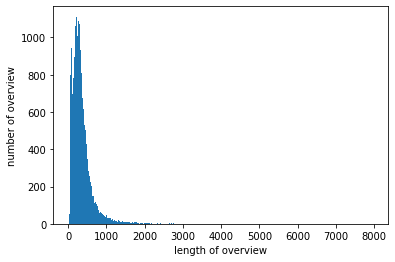

In [ ]:
text_len = [len(i) for i in df['overview'].values]
max_len = max(text_len)
avg_len = sum(text_len) / len(text_len)
print(f'overview의 최대 길이: {max_len}, 평균 길이: {avg_len}')
plt.hist(text_len, bins=300)
plt.xlabel('length of overview')
plt.ylabel('number of overview')
plt.show()

In [ ]:
max_len = 1000
count = 0
for sentence in df['overview'].values:
    if len(sentence) <= max_len:
        count += 1
print(f'전체 데이터 중 길이가 {max_len} 이하인 데이터의 비율: {count / len(df)}')

전체 데이터 중 길이가 1000 이하인 데이터의 비율: 0.9706817379018015


In [ ]:
df_train, df_valid, _, _ = train_test_split(df, df['cat3'], test_size=0.2, random_state=config['SEED'])
df_train.shape, df_valid.shape

((13588, 6), (3398, 6))

In [ ]:
for col in ['cat1', 'cat2', 'cat3']:
    le = LabelEncoder()
    le.fit(df[col].values)
    df_train[col] = le.transform(df_train[col].values)
    df_valid[col] = le.transform(df_valid[col].values)

In [ ]:
df_train.head()

,id,img_path,overview,cat1,cat2,cat3
1786,TRAIN_01786,./image/train/TRAIN_01786.jpg,함평양서파충류생태공원은 전남 함평군 신광면에 자리 잡고 있다. 공원 내에는 양서류를...,4,4,44
16670,TRAIN_16670,./image/train/TRAIN_16670.jpg,국제수변레포츠 단지 내 위치한 충주 탄금호 캠핑 리조트는 다양한 문화체험이 가능한 ...,0,11,73
3377,TRAIN_03377,./image/train/TRAIN_03377.jpg,경남 함양군 서하면에 위치한 함양 라온캠핑장은 마운틴뷰의 조용하고 깨끗한 신설 캠핑...,0,11,73
12814,TRAIN_12814,./image/train/TRAIN_12814.jpg,캠프바베큐는 충남 천안시 동남구에 자리 잡고 있다. 천안시청을 기점으로 약 8㎞가량...,0,11,73
2607,TRAIN_02607,./image/train/TRAIN_02607.jpg,"원수산습지생태원은 세종시 연기면 세종리에 있다. 생태원 내에는 보존습지, 수생식물습...",5,13,93


In [ ]:
def generator_train():
    for item in df_train.values:
        yield (item[0], item[1:-1], item[-1])

def generator_valid():
    for item in df_valid.values:
        yield (item[0], item[1:-1], item[-1])
    
dataset_train = tf.data.Dataset.from_generator(
    generator_train,
    (tf.string, tf.float32, tf.int32),
    ((), (23,), ())
    )

dataset_valid = tf.data.Dataset.from_generator(
    generator_valid,
    (tf.string, tf.float32, tf.int32),
    ((), (23,), ())
    )

def augmentation(image):
    h, w = image.shape[0], image.shape[1]
    size = h if h > w else w
    dst = pad_to_bounding_box(image, int((size-h)/2), int((size-w)/2), size, size)
    dst = resize(dst, size=(config['IMG_SIZE'], config['IMG_SIZE']))

    dst = random_flip_left_right(dst)
    dst = tf.cast(dst, tf.float32)
    dst /= 255

    return dst

def preprocessing(path, category, label):
    label = tf.one_hot(label, 2)
    bin = tf.io.read_file(path)
    image = tf.io.decode_png(bin, channels=3)
    image= tf.py_function(augmentation, [image], [tf.float32])
    image = tf.squeeze(image)
    return (image, category), label

dt = dataset_train.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dt = dt.batch(config['BATCH_SIZE']).prefetch(3)
dv = dataset_valid.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dv = dv.batch(config['BATCH_SIZE']).prefetch(3)

In [ ]:
class CustomDataset(tf.data.Dataset):
    # def __init__(self, img_path, text_vectors, label_list, transforms, infer=False):
    def __init__(self, img_path, text, labels):
        self.img_path = img_path
        self.text = text
        self.labels = labels
        # self.transforms = transforms
        # self.infer = infer
        
    def __getitem__(self, index):
        # NLP
        text_vector = np.array(tokenizer.encode(self.text[index]), dtype=np.int32)
        text_vector = tf.cast(text_vector, tf.float32)
        # Image
        img_path = self.img_path[index]
        bin = tf.io.read_file(img_path)
        image = tf.io.decode_png(bin, channels=3)
        image = resize(image, size=(config['IMG_SIZE'], config['IMG_SIZE']))
        image = tf.cast(image, tf.float32)
        image /= 255
        label = tf.cast(self.labels[index], tf.int32)
        return (image, text_vector), label
        
    def __len__(self):
        return len(self.img_path)
    
    def _inputs(self):
        return []

    def element_spec(self):
        return (
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32, name='image'),
            tf.TensorSpec(shape=(None,), dtype=tf.float32, name='text'),
            tf.TensorSpec(shape=(), dtype=tf.int32, name='labels'),
        )

def generator():
    for i in range(len(custom_dataset)):
        yield custom_dataset[i]
        
custom_dataset = CustomDataset(df_train['img_path'].values, df_train['overview'].values, df_train['cat3'].values)
dataset = tf.data.Dataset.from_generator(generator, output_types=(tf.float32, tf.float32, tf.int32))

In [ ]:
dataset

<FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [ ]:
'''
This error is indicating that the structure of the elements being yielded by a generator in the TensorFlow code does not match the expected structure. Specifically, the expected structure is (tf.float32, tf.float32, tf.int32), but the yielded element was ((tf.Tensor(shape=(224, 224, 3), dtype=float32, numpy=...), tf.Tensor(shape=(109,), dtype=float32, numpy=...)).

This could be caused by a variety of issues, such as the generator yielding data with the wrong shape or type, or the TensorFlow code expecting a different structure than what the generator is providing.

To fix this error, you will need to inspect the code to identify where the generator is defined and how it is being used. You may need to modify the code to ensure that the generator yields elements with the expected structure.
'''

In [ ]:
for (image, overview), labels in dataset:
    print(image.shape)
    print(tokenizer.decode(overview))
    print(labels)
    plt.imshow(image)
    plt.show()

InvalidArgumentError: ignored

In [ ]:
def generator_train():
    for item in df_train.values:
        yield (item[1], item[2], item[3:])

def generator_valid():
    for item in df_valid.values:
        yield (item[1], item[2], item[3:])
    
dataset_train = tf.data.Dataset.from_generator(
    generator_train,
    (tf.string, tf.string, tf.int32),
    ((), (), (3,))
    )

dataset_valid = tf.data.Dataset.from_generator(
    generator_valid,
    (tf.string, tf.string, tf.int32),
    ((), (), (3,))
    )

def augmentation(image):
    h, w = image.shape[0], image.shape[1]
    size = h if h > w else w
    dst = pad_to_bounding_box(image, int((size-h)/2), int((size-w)/2), size, size)
    dst = resize(dst, size=(config['IMG_SIZE'], config['IMG_SIZE']))

    dst = random_flip_left_right(dst)
    dst = tf.cast(dst, tf.float32)
    dst /= 255

    return dst

def encoding(text):
    return tokenizer.encode(text)

def preprocessing(path, overview, labels):
    bin = tf.io.read_file(path)
    image = tf.io.decode_png(bin, channels=3)
    image = tf.py_function(augmentation, [image], [tf.float32])
    image = tf.squeeze(image)

    vector = tf.py_function(encoding, [overview], [tf.int32])
    return (image, vector), labels

dt = dataset_train.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dt = dt.batch(config['BATCH_SIZE']).prefetch(3)
dv = dataset_valid.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dv = dv.batch(config['BATCH_SIZE']).prefetch(3)

In [ ]:
for (image, overview), labels in dt.take(1):
    print(image[0].shape)
    print(tokenizer.decode(overview[0]))
    print(labels[0])
    plt.imshow(image[0])
    plt.show()

InvalidArgumentError: ignored

In [ ]:
np.array(tokenizer.encode(df.values[0][2]), dtype=np.int32)

array([14081, 11699, 13603, 12005, 18478, 13590, 16020, 14027, 16110,
       13607, 16789, 14249, 12141, 13607, 24410, 19509, 12034, 14116,
       14256, 14649, 15709, 14904, 16365, 12007, 24294, 16390, 17017,
        9497, 11465, 13173, 22447, 15885, 22564, 14577, 22225, 23057,
       26341, 12074, 14167, 16020, 17726, 14180, 20127, 10281, 13590,
       14923, 14508, 22777,  1700, 18507, 20529, 16390, 14055, 10612,
       14089, 16020, 12024, 14045, 18698, 17017, 12024, 21076, 15065,
       15673, 26957, 14082, 14937, 22564, 21931, 16020, 14147, 14319,
       11465, 11802, 24381,   243, 26031, 10769, 11973, 14624, 14193,
       15693, 15750, 15199, 19174, 16127, 16908, 14045, 11940, 15046,
       11763, 12147, 15046, 11320, 12034, 21593, 15964,   259,   297,
         313,   261], dtype=int32)

In [ ]:
tokenizer.decode(tokenizer.encode(df.values[0][2]))